### This notebook features 4 methods of generating gaussian processes. Two covariance methods and two spectral methods.

In [33]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt 
import random 
import math
import cmath

# Covariance methods
#### (slow, but 100% correct)


## Method 1 
The slowest one 

In [ ]:
# examples of covariance functions 

def K_Linear(s,t):
    return abs(s-t)

def Sinc(s, t):
    return np.sinc(s-t)

def K_Wiener(s, t):
    return min(s, t)

def K_RBF(s, t):
    return np.exp(-0.5 * abs(s-t)**2)

def K_brownian_bridge(s, t):
    return min(s, t) - s*t

def exponential(s, t):
    return np.exp(-abs(s-t))

def wave(s,t):
    return np.cos(s-t)

a = np.linspace(2, 5, 4)
b = np.linspace(4, 7, 5)
print(a)
print(b)
get_cov(wave, a, b)


In [ ]:
# examples of mean functions 
def square(s):
    return s*s

def linear(s):
    return s

def zero(s):
    return 0

In [28]:
# preparatory function 
def get_cov(f, points1, points2):
    """Return covariance matrix for the sets of points given according to covariance function f"""
    size1 = points1.shape[0]
    size2 = points2.shape[0]
    cov = np.empty((size1, size2)) 
    for i in range(size1):
        for j in range(size2):
            cov[i, j] = f(points1[i], points2[j])
    return cov  

In [29]:
def simulate_GP(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, ls = True):
    """Return number_of_function gaussian functions built on interval [left_border, right_border] 
       with mean value = mean_function
       and covariance function = cov_function.
       Each function is built by means of nb_of_samples values
       which are evenely spaced on interval [left_border, right_border].
       Build a pocture in case ls = True.
    """
    
    points = np.linspace(left_border, right_border, nb_of_samples)
    Σ = get_cov(cov_function, points, points)
    mean_vals = [mean_function(point) for point in points]
    ys = np.random.multivariate_normal(
                                       mean_vals,
                                       cov=Σ,
                                       size=number_of_functions)
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    
    for i in range(number_of_functions):
        if ls:
            plt.plot(points, ys[i])
            plt.plot(points, np.zeros_like(points), color = 'green') 
    return ys, fig

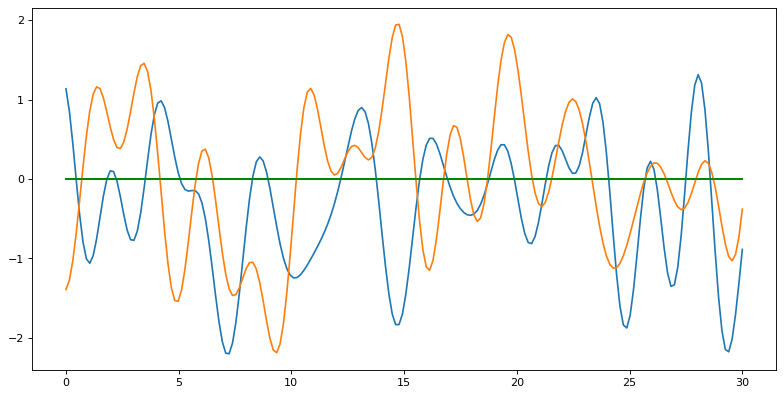

In [32]:
a = simulate_GP(zero, Sinc, 200, 2, 0, 30)

## Method 2

This method is faster then the previous one. It works due to the folowing algorithm: firstly, it builts a set of gaussian points on a small interval using method 1. After that, this first set of points built on the small interval is considered to have a prior distribution, so that we can calculate some new posterior distribution using this values. Next set of values will be generated on the adjacent interval due to this posterior distribution. This iteration can be repeated in order to built a function on a bigger interval. 

In [35]:
# Computation of posterion distribution according to given values 
def Gaussian_Posterior(X1, y1, X2, kernel_func):
    """
    X1 --- vector of time points 
    y1 --- vector of values for points from X1
    (X1, y1) --- data with prior distribution
    kernel_func --- covariance function
    Returns:
    μ2  --- posterior mean vector
    Σ2 --- posterior covariance matrix
    """
    # Kernel of the observations
    N = X1.shape[0]
    add = np.eye(N)
    Σ11 = get_cov(kernel_func, X1, X1) + add*10e-8
    # Kernel of observations vs to-predict
    Σ12 = get_cov(kernel_func, X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = get_cov(kernel_func, X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [36]:
def Posterior3(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, iterations, ls = True):
    """Generate number_of_function functions.
       For each function firstly create number_of_samples gaussian values on interval
       [left_border, right_border] with mean function = mean function and covariance function = cov_function
       Repeate the algorithm above 'iterations' times.
       Bulid a picture in case ls = True.
    """
    
    len_interval = (right_border - left_border) / (iterations+1)
    delta = len_interval/(nb_of_samples - 1)

    final_y = np.zeros((number_of_functions, (iterations+1)*nb_of_samples))
    # create initial values using solution 1
    X1 = np.linspace(left_border, left_border+len_interval, nb_of_samples)
    y1, fig = simulate_GP(mean_function, 
                          cov_function,
                          nb_of_samples,
                          number_of_functions,
                          left_border,
                          left_border+len_interval,
                          ls = False)
    
    for func in range(number_of_functions): 
        y = np.zeros((iterations+1, nb_of_samples))
        X = np.zeros((iterations+1, nb_of_samples))
        y[0,:] = y1[func]
        X[0,:] = X1
        for it in range(1, iterations+1):
            X2 = np.linspace(left_border + len_interval*it, left_border + len_interval*(it+1), nb_of_samples)
            #compute posterior distribution 
            μ2, Σ2 = Gaussian_Posterior(X[it-1,:], y[it-1,:], X2, cov_function)
            #generate new samples
            y[it, :] = np.random.multivariate_normal(μ2, cov=Σ2)
            X[it, :] = X2
            
        X = np.reshape(X,((iterations+1)*nb_of_samples,))  
        final_y[func] = np.reshape(y,((iterations+1)*nb_of_samples,))
        if ls:       
            plt.plot(X, final_y[func], figure = fig)
            plt.plot(X, np.zeros_like(X), color = 'green')     
         
    if ls:
        plt.show() 
    return final_y, fig  

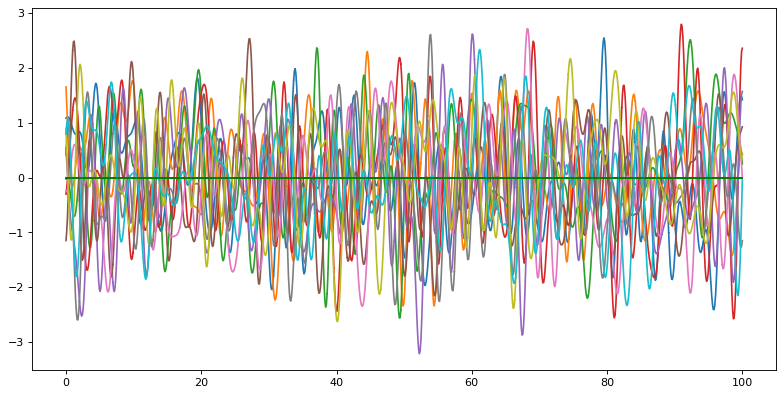

In [37]:
a = Posterior3(zero, Sinc, 10, 10, 0, 100, 100)

# Spectral methods 

### (work fast, but I don't trust them very much for non-step density measures, also return only functions with zero mean) 

In [38]:
# examples of density functions

def gaussian(x):
    return np.exp(-0.5 * abs(x)**2)

def rect(x):
    if abs(x) > 1/2:
        return 0
    else:
        return 1
    
def strange_density(x):
    if abs(x) <= 0.08:
        return 0
    elif 0.08 <= abs(x) <= 0.16:
        return 500
    elif 0.16 <= abs(x) <= 0.32:
        return 10
    else:
        return 0 
    

## Method 3
### detailed in the article https://faculty.washington.edu/dbp/PDFFILES/Interface-92-all.pdf

In [42]:
# preparatory function 

def U_scale(sp_density, M, scale):
    """spectral_density --- density measure of the gaussian process,
       M --- build functions on interval [0, M],
       scale --- cut-off frequency for the density measure. We will consider the measure only on interval [-scale, scale].
    """
    W = [random.gauss(0, 1) for i in range(M)]
    U = []
    U.append(math.sqrt(sp_density(0))* W[0])
    for j in range(1, int(M/2)):
        u = complex(W[2*j-1], W[2*j])
        U.append(math.sqrt(0.5 * sp_density(scale*j/M)) * u)
    U.append(math.sqrt(0.5 * sp_density(scale*0.5)) * W[M-1])
    
    for j in range(int(M/2) + 1, M):
        U.append(np.conjugate(U[M-j]))
    return U    

In [50]:
def generate_GP_scale(density, M, number_of_functions, scale, ls = True):
    """spectral_density --- density measure of the gaussian process,
       M --- build finctions on interval [0, M],
       number_of_functions --- number of functions to generate,
       scale --- cut-off frequency for the density measure. We will consider the measure only on interval [-scale, scale],
       ls --- build a picture if true.
    """
    Uj = [U_scale(density, M, scale) for i in range(number_of_functions)]
    Y = np.empty((number_of_functions, M))
    Y = [np.fft.fft(Uj[i])/np.sqrt(M) for i in range(number_of_functions)]
    for func in range(number_of_functions):
        Y[func] = [y.real for y in Y[func]]
    N = [i for i in range(M)]
    if ls:
        fig = plt.figure(figsize=(15, 5), dpi=80)
        for func in range(number_of_functions):
            plt.plot(N, Y[func])


        plt.plot(N, np.zeros_like(N), color='green')    
        plt.show()     
    return Y

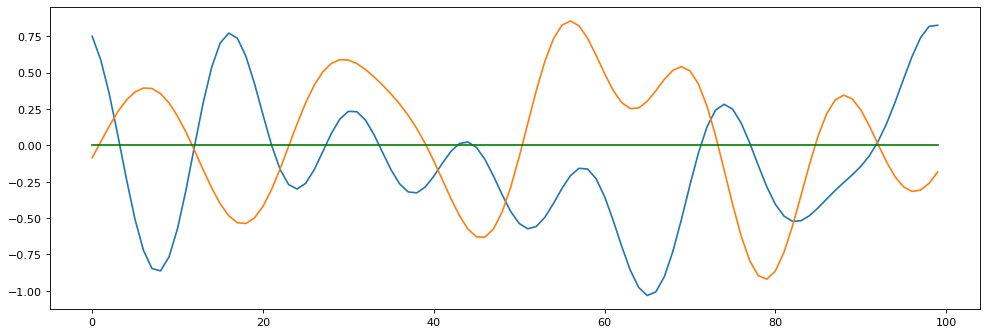

In [51]:
a = generate_GP_scale(rect, 100, 2, 7, ls = True)

## Method 4
### detailed in the article https://www.researchgate.net/publication/282628530_Generating_Stationary_Gaussian_Processes_Using_The_Spectral_Representation_Theorem

In [22]:
# scale is a cut-off frequency for spectral density, i.e. maximum LINEAR frequency of discrete signal
def GP(density, delta, M, scale, number_of_points, number_of_functions = 1, ls = True):
    """density --- density measure of the gaussian process,
       delta --- distance between density sample points, 
       M --- build finctions on interval [0, M],
       number_of_functions --- number of functions to generate,
       scale --- cut-off frequency for the density measure. We will consider the measure only on interval [-scale, scale],
       ls --- build a picture if true.
    """
    N = int(scale/delta)
    x_density = np.linspace(0, scale, N+1) # 2*pi*x_density[k] = omega_k from paper
    coeff = np.sqrt([2*density(x)*delta for x in x_density])
    
    points = np.linspace(0, M, number_of_points)
    X = np.zeros((number_of_functions, number_of_points))
    plt.figure(figsize=(15, 5), dpi=80)
    for func in range(number_of_functions):
        W = [random.gauss(0,1) for i in range(2*N + 2)]

        for i, point in enumerate(points):
            for j in range(N+1):
                X[func, i] += coeff[j] * (np.sin(x_density[j]*point*2*np.pi) * W[j] + np.cos(x_density[j]*point*2*np.pi) * W[j+N])
        if ls:
            plt.plot(points, X[func])
    if ls:    
        plt.plot(points, np.zeros_like(points), color='green')    
        plt.show()
    return X





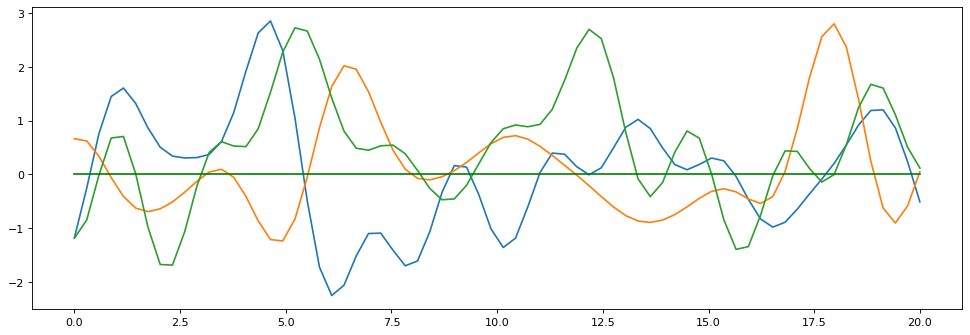

In [23]:
a = GP(rect, 0.01, 20, 5, 70, 3)